In [1]:
# Librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sb
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import pyclustertend 
import random
from sklearn.decomposition import PCA

In [2]:
# Configuración inicial

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dataset=pd.read_csv("movies.csv", encoding="latin1")

## Datos que no aportan información

id, title y original_title son datos que sirven más como nombres o identificadores de los datos, por lo que dentro de los grupos no aportarian mucha información.

homepage es solo un link a una página web, por lo que tampoco es relevante.

video solo tiene datos de si y no, pero no demuestra el alcance publicitario que tuvo la película. Por lo tanto, se vuelve irrelevante.

actorsCharacter solo indica los nombres de los personajes que interpretaron los actores dentro de sus respectivas película, nada que aporte información relevante.

productionCompany, productionCompanyCountry, productionCountry, productionCoAmount y productionCountriesAmount todos estos son datos sobre la producción de las películas. Estos datos pueden llegar a afectar mucho en una pelicula, pero en una agrupación es difícil darles lugar, ya que suelen ser muy variados

director indica el o los nombres de quien dirigió la película. Esto en un clustering no es muy útil, ya que no da para agrupaciones claras, pues no es como que se pueda saber la cálidad de un director solo por su nombre. Además, no hay forma de usar este dato para categorizar a los directores de forma directa.

actors indica los nombres de los actores y actrices que se ven involucrados en una película. Al igual que el director, esto no ayuda a las agrupaciones.

actorsAmount, castWomenAmount y castMenAmount son los datos sobre la cantidad de acatores y actrices dentro del elenco de la película. Aunque es un dato importante, ocurre lo mismo que con la producción, es un dato tan variado que puede ser difíl crear una agrupación fiel con ellos.

## Datos que pueden ser útiles para calcular los grupos

popularity es el índice de popularidad que tuvo la película semanalmente.

budget es la variable numérica que permite ver el presupuesto de las películas.

revenue es la variable numérica que muestra los ingresos de cada película.

voteAvg y voteCount ayudan a identificar las películas con mejor calificación y con más interacciones.

actorsAmount es la variable numérica que dice cuantos actores tiene cada película.

genresAmount es el valor numérico que se puede usar para saber como se agrupan películas con diferentes cantidades de géneros.

genres es un valor cualitativo que nos dice específicamente que generos tiene cada película. En este valor se pueden codificar los datos para un mejor análisis.

releaseDate es la varoable dada en formato de fecha que indica cuando se estrenó la pelicula.

actorsPopularity muestra la popularidad de cada actor dentro de la película. De esta lista se sacará un promedio para poder tratar mejor los datos. 

El enfoque de los grupos será ver las características de las películas que han sido un exito comercial


In [3]:
# limpia de datos con |

dataset['prime_genre'] = dataset['genres'].str.split('|').str[0]

def popularity_avg(actores_pop):
    try:
        valores = [float(x) for x in actores_pop.split('|') if x.replace('.', '', 1).isdigit()]
        return sum(valores) / len(valores) if valores else None 
    except:
        return None


dataset['actorsPopularity_avg'] = dataset['actorsPopularity'].apply(lambda x: popularity_avg(str(x)))

# Tomar solo el año de estreno

dataset['releaseDate'] = pd.to_datetime(dataset['releaseDate'], errors='coerce')
dataset['releaseYear'] = dataset['releaseDate'].dt.year


C:\Users\dgv31\AppData\Local\Temp\ipykernel_40860\3760735514.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  dataset_filtered.hist(ax=axs)


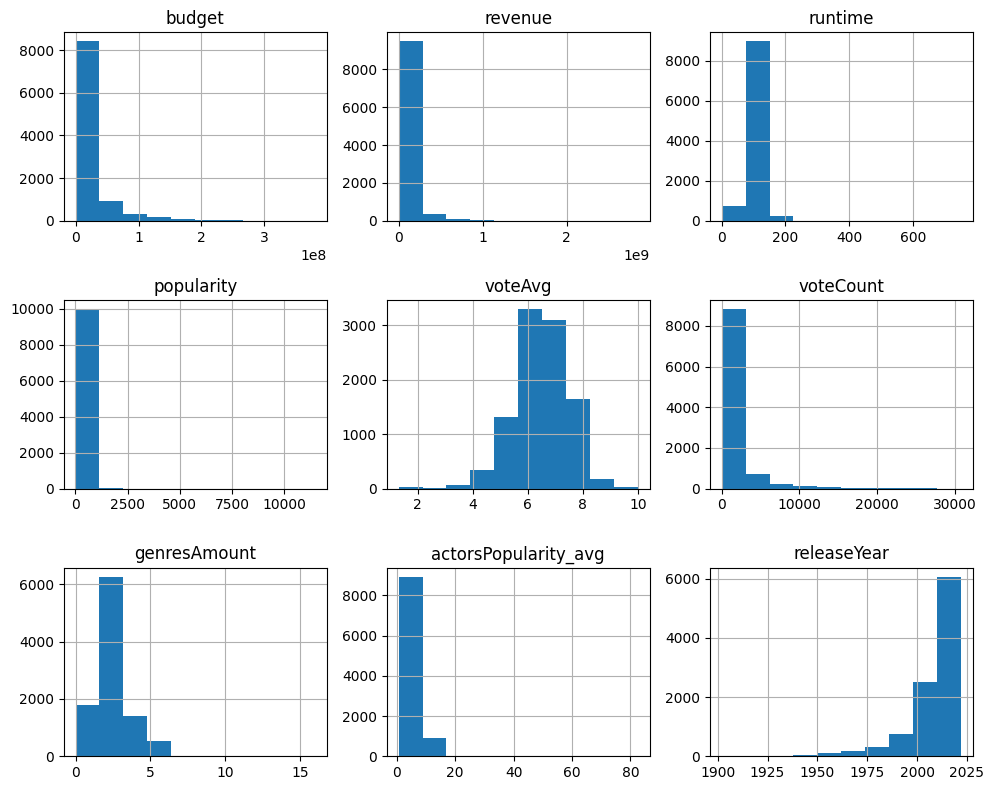

In [4]:
fig, axs = plt.subplots( figsize=(10, 8))
dataset_filtered = dataset.drop(['id', 'originalTitle', 'title', 'homePage', 'video', 'actors', 'director', 'actorsCharacter', 'actorsAmount', 'castWomenAmount', 'castMenAmount', 'productionCompanyCountry', 'productionCountry', 'productionCoAmount', 'productionCountriesAmount', 'productionCompany', 'genres', 'actorsPopularity','releaseDate'], axis='columns')
dataset_filtered.hist(ax=axs)
plt.tight_layout()
plt.show()

In [5]:
X = np.array(dataset_filtered[['budget','popularity']])
Y = np.array(dataset_filtered[['revenue']])
X.shape

(10000, 2)

In [6]:
# Fijar la semilla para obtener resultados reproducibles
random.seed(123)

# Escalar los datos para normalización
X_scale = sklearn.preprocessing.scale(X)

# Calcular la estadística de Hopkins
hopkins_stat = pyclustertend.hopkins(X_scale, len(X_scale))
print(f'Estadística de Hopkins: {hopkins_stat}')


Estadística de Hopkins: 0.003381785300763093


In [ ]:
# pyclustertend.vat(X_scale)

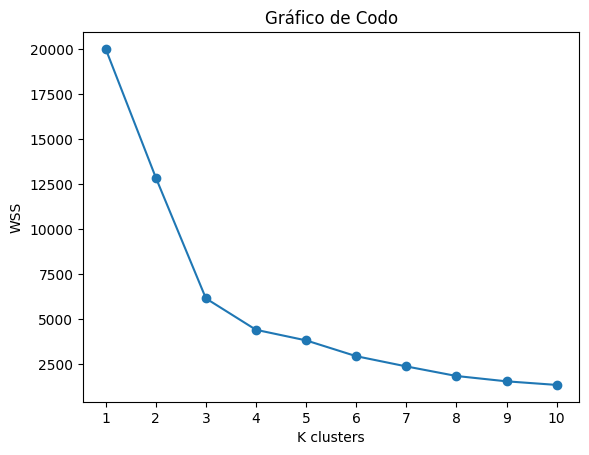

In [8]:
numeroClusters = range(1,11)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scale)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss, marker='o')
plt.xticks(numeroClusters)
plt.xlabel("K clusters")
plt.ylabel("WSS")
plt.title("Gráfico de Codo")
plt.show()

Este gráfico de codo nos muestra que la suma de wss no tiene un descenso gradual hasta que k = 4.